In [1]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score

In [2]:
from aeon.datasets import load_classification

X, y = load_classification("ECG200")

y = np.where(y == '-1', 0, y)
y = y.astype(np.float64)

features_train, features_test, y_train, y_test = train_test_split(features, y, test_size=0.2, random_state=1234)

## Model Training

### Simple LSTM

In [3]:
import tensorflow as tf
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout

def create_lstm_model(sequence_length, n_features):
    model = Sequential([
        LSTM(32, input_shape=(sequence_length, n_features), return_sequences=True),
        Dropout(0.2),
        LSTM(16),
        Dropout(0.2),
        Dense(8, activation='relu'),
        Dense(1, activation='sigmoid')
    ])

    model.compile(
        optimizer='adam',
        loss='binary_crossentropy',
        metrics=['accuracy']
    )

    return model

In [4]:
sequence_length = 1
n_features = 96

lstm = create_lstm_model(sequence_length, n_features)

# Training
lstm.fit(X_train, y_train, epochs=30, batch_size=8, validation_split=0.2)

Epoch 1/30
16/16 [==============================] - 7s 107ms/step - loss: 0.6664 - accuracy: 0.7500 - val_loss: 0.6584 - val_accuracy: 0.5312
Epoch 2/30
16/16 [==============================] - 0s 8ms/step - loss: 0.6228 - accuracy: 0.7266 - val_loss: 0.6308 - val_accuracy: 0.6250
Epoch 3/30
16/16 [==============================] - 0s 8ms/step - loss: 0.5653 - accuracy: 0.7344 - val_loss: 0.6029 - val_accuracy: 0.6250
Epoch 4/30
16/16 [==============================] - 0s 9ms/step - loss: 0.5017 - accuracy: 0.7891 - val_loss: 0.5791 - val_accuracy: 0.6562
Epoch 5/30
16/16 [==============================] - 0s 8ms/step - loss: 0.4477 - accuracy: 0.8281 - val_loss: 0.5837 - val_accuracy: 0.7188
Epoch 6/30
16/16 [==============================] - 0s 8ms/step - loss: 0.4056 - accuracy: 0.8750 - val_loss: 0.5505 - val_accuracy: 0.7500
Epoch 7/30
16/16 [==============================] - 0s 8ms/step - loss: 0.3624 - accuracy: 0.8750 - val_loss: 0.5634 - val_accuracy: 0.7500
Epoch 8/30
16/16 [

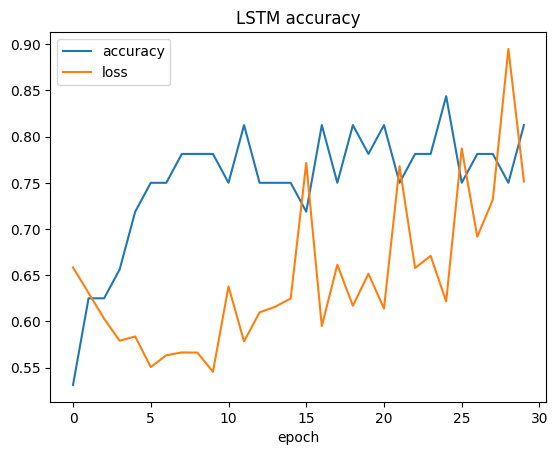

In [5]:
# plot val_accuracy and val_loss per epoch
history = lstm.history.history

plt.plot(history['val_accuracy'])
plt.plot(history['val_loss'])
plt.title('LSTM accuracy')
plt.xlabel('epoch')
plt.legend(['accuracy', 'loss'], loc='upper left')
plt.show()

In [6]:
LSTM_pred = lstm.predict(X_test)
bin_LSTM_pred = np.where(LSTM_pred > 0.5, 1, 0)

LSTM_accuracy = accuracy_score(y_test, bin_LSTM_pred)
print(f"Accuracy: {LSTM_accuracy}")

2/2 [==============================] - 2s 5ms/step
Accuracy: 0.85


### Catch22

In [7]:
import numpy as np
import pandas as pd
import pycatch22

def compute_catch22_features(X):
    if isinstance(X, pd.DataFrame):
        X = X.values

    # Ensure X is a 2D numpy array
    X = np.asarray(X)
    if X.ndim == 1:
        X = X.reshape(1, -1)

    # Get feature names from first valid time series
    feature_names = pycatch22.catch22_all(X[0].flatten())['names']

    # Initialize array to store all features
    all_features = np.zeros((len(X), len(feature_names)))

    # Compute features for each time series
    for i, series in enumerate(X):
        try:
            # Ensure the series is 1D
            series = series.flatten()
            features = pycatch22.catch22_all(series)['values']
            all_features[i] = features
        except Exception as e:
            print(f"Error processing series {i}: {str(e)}")
            # You might want to handle this error differently depending on your needs
            all_features[i] = np.nan

    # Create DataFrame with feature names
    df_features = pd.DataFrame(all_features, columns=feature_names)

    return df_features

# Usage example:
catch22_X = compute_catch22_features(X)

In [8]:
catch22_X.head()

,DN_HistogramMode_5,DN_HistogramMode_10,CO_f1ecac,CO_FirstMin_ac,CO_HistogramAMI_even_2_5,CO_trev_1_num,MD_hrv_classic_pnn40,SB_BinaryStats_mean_longstretch1,SB_TransitionMatrix_3ac_sumdiagcov,PD_PeriodicityWang_th0_01,...,FC_LocalSimple_mean1_tauresrat,DN_OutlierInclude_p_001_mdrmd,DN_OutlierInclude_n_001_mdrmd,SP_Summaries_welch_rect_area_5_1,SB_BinaryStats_diff_longstretch0,SB_MotifThree_quantile_hh,SC_FluctAnal_2_rsrangefit_50_1_logi_prop_r1,SC_FluctAnal_2_dfa_50_1_2_logi_prop_r1,SP_Summaries_welch_rect_centroid,FC_LocalSimple_mean3_stderr
0,1.045195,0.839203,12.897849,36.0,0.648035,-0.000608,0.778947,45.0,0.041667,8.0,...,0.250000,-0.854167,-0.281250,0.965965,8.0,1.692256,0.800000,0.428571,0.098175,0.344165
1,0.302434,0.545679,7.978666,20.0,0.297887,0.003755,0.947368,24.0,0.040000,7.0,...,0.062500,0.072917,-0.552083,0.791941,5.0,1.820093,0.742857,0.600000,0.147262,0.662674
2,0.614779,0.805575,12.790413,34.0,0.852492,0.000112,0.747368,46.0,0.041667,0.0,...,0.250000,-0.833333,-0.281250,0.970727,7.0,1.541627,0.771429,0.428571,0.098175,0.308408
3,0.133587,0.333877,10.746980,33.0,0.734938,0.001211,0.715789,42.0,0.040000,0.0,...,0.111111,-0.010417,-0.208333,0.943879,13.0,1.411409,0.771429,0.685714,0.098175,0.324871
4,0.730631,0.458123,8.122401,26.0,0.582694,0.014157,0.831579,42.0,0.054422,4.0,...,0.153846,-0.906250,-0.416667,0.873607,7.0,1.665792,0.771429,0.200000,0.147262,0.508570


In [9]:
from sklearn.ensemble import RandomForestClassifier

catch22_X_train, catch22_X_test, catch22_y_train, catch22_y_test = train_test_split(catch22_X, y, test_size=0.2, random_state=1234)

clf = RandomForestClassifier(random_state=42)
clf.fit(catch22_X_train, catch22_y_train)

catch22_pred = clf.predict(catch22_X_test)

catch22_accuracy = accuracy_score(catch22_y_test, catch22_pred)
print(f"Accuracy: {catch22_accuracy}")

Accuracy: 0.85


### ROCKET

In [10]:
import numpy as np
from rocket.code.rocket_functions import generate_kernels, apply_kernels
from sklearn.linear_model import RidgeClassifierCV

# reshape the input data by removing the middle dimension if it exists
X_train = np.squeeze(X_train, axis=1) if len(X_train.shape) == 3 and X_train.shape[1] == 1 else X_train
X_test = np.squeeze(X_test, axis=1) if len(X_test.shape) == 3 and X_test.shape[1] == 1 else X_test

# Generate random kernels
kernels = generate_kernels(X_train.shape[-1], 10_000)

# Transform training set and train classifier
X_train_transform = apply_kernels(X_train, kernels)
print(X_train_transform.shape)

# Train the classifier
rocket = RidgeClassifierCV(alphas=np.logspace(-3, 3, 10))
rocket.fit(X_train_transform, y_train)

(160, 20000)


RidgeClassifierCV(alphas=array([1.00000000e-03, 4.64158883e-03, 2.15443469e-02, 1.00000000e-01,
       4.64158883e-01, 2.15443469e+00, 1.00000000e+01, 4.64158883e+01,
       2.15443469e+02, 1.00000000e+03]))

In [11]:
# Transform test set and predict
X_test_transform = apply_kernels(X_test, kernels)
rocket_pred = rocket.predict(X_test_transform)

rocket_accuracy = accuracy_score(y_test, rocket_pred)
print(f"Accuracy: {rocket_accuracy}")

Accuracy: 0.925


## Borderline Examples with DTW Distance

In [12]:
from aeon.distances import dtw_distance

def get_DTW_distance(X: pd.DataFrame) -> np.ndarray:
    distances = np.zeros((X.shape[0], X.shape[0]))

    # get distance matrix
    for i in range(X.shape[0]):
        for j in range(i + 1, X.shape[0]):
            distance = dtw_distance(X[i], X[j])
            distances[i, j] = distance
            distances[j, i] = distance

    # get the indices of the 5 closest points
    closer_neighbors = np.argsort(distances, axis=1)[:, 1:6]
    return closer_neighbors


def get_Borderline_Binary(closer_neighbors: np.ndarray, y: np.ndarray) -> dict:
    borderline_pairs = {}

    for i in range(len(closer_neighbors)):
        own_class = [n for n in closer_neighbors[i] if y[i] == y[n]]
        other_class = [n for n in closer_neighbors[i] if y[i] != y[n]]

        if abs(len(own_class) - len(other_class)) == 1:
            borderline_pairs[i] = other_class

    return borderline_pairs

In [13]:
closer_N = get_DTW_distance(X_test)
borderline_pairs = get_Borderline_Binary(closer_N, y_test)

print(borderline_pairs)

{8: [16, 1, 30], 10: [36, 19], 12: [16, 1, 30], 16: [29, 8, 12], 20: [30, 7], 25: [19, 36], 28: [19, 36], 30: [29, 20], 36: [10, 8, 12]}


## Morphing and Sensitivity

### Per Instance Analysis


In [14]:
import numpy as np
import tensorflow as tf
import importlib
tsmorph = importlib.import_module('tsmorph-xai.tsmorph.tsmorph')
TSmorph = tsmorph.TSmorph


morphing = TSmorph(S=X[1], T=X[2], granularity=10).transform()

print(X[1].shape)


(1, 96)


In [41]:
import numpy as np
import tensorflow as tf
import importlib
tsmorph = importlib.import_module('tsmorph-xai.tsmorph.tsmorph')
TSmorph = tsmorph.TSmorph


def MorphingCalculater(X_morph, y_morph, borderline_pairs, model, granularity=20, rocket_kernels=None, catch22_features=False):
    pairs = []
    # create list of tuples (key, element[i])
    for key in borderline_pairs:
        for i in range(len(borderline_pairs[key])):
            pairs.append([key, borderline_pairs[key][i]])

    print(pairs)
    morphs = []
    results = {}
    metrics = {}

    for sample in pairs:
        source_ts = X_morph[sample[0]].reshape(1,-1)
        target_ts = X_morph[sample[1]].reshape(1,-1)


        # apply morphing
        morphing = TSmorph(S=source_ts, T=target_ts, granularity=granularity+2).transform()
        morphing = morphing.T

        # Predict new labels using selected model
        if isinstance(model, tf.keras.Model):
            morphing = morphing.to_numpy()
            if len(morphing.shape) != 3:  # Ensure it has 3 dimensions (samples, sequence_length, features)
                morphing = morphing.reshape(morphing.shape[0], 1, morphing.shape[1])

            print(morphing.shape)
            pred = model.predict(morphing)
            pred = np.where(pred > 0.5, 1, 0)

        elif catch22_features:
            features = compute_catch22_features(morphing)
            pred = model.predict(features)

        elif rocket_kernels is not None:  # Fixed variable name from kernels to rocket_kernels
            morphing = np.array(morphing, dtype=np.float64)
            morphing_transform = apply_kernels(morphing, rocket_kernels)
            pred = model.predict(morphing_transform)

        # check if model predictions align with ground truth
        if (y_morph[sample[0]] == pred[0] and y_morph[sample[1]] == pred[-1]):
            # calculate morphing percentage
            change_idx = 1
            for i in range(1, len(pred)-1):  # account for both original series
                if pred[0] != pred[i]:
                    change_idx = i
                    break
            morph_perc = 1/granularity * change_idx
            morphs.append(morph_perc)

            results[(sample[0], sample[1])] = round(morph_perc, 2)
        else:
            continue

    # Calculate metrics only if morphs list is not empty
    if morphs:
        metrics['mean'] = float(np.mean(morphs))
        metrics['std'] = float(np.std(morphs))
    else:
        metrics['mean'] = 0.0
        metrics['std'] = 0.0

    return results, metrics

In [42]:
res = MorphingCalculater(X_test, y_test, borderline_pairs, model=lstm)
res

[[8, 16], [8, 1], [8, 30], [10, 36], [10, 19], [12, 16], [12, 1], [12, 30], [16, 29], [16, 8], [16, 12], [20, 30], [20, 7], [25, 19], [25, 36], [28, 19], [28, 36], [30, 29], [30, 20], [36, 10], [36, 8], [36, 12]]
(22, 1, 96)
1/1 [==============================] - 0s 38ms/step
(22, 1, 96)
1/1 [==============================] - 0s 38ms/step
(22, 1, 96)
1/1 [==============================] - 0s 38ms/step
(22, 1, 96)
1/1 [==============================] - 0s 44ms/step
(22, 1, 96)
1/1 [==============================] - 0s 39ms/step
(22, 1, 96)
1/1 [==============================] - 0s 41ms/step
(22, 1, 96)
1/1 [==============================] - 0s 38ms/step
(22, 1, 96)
1/1 [==============================] - 0s 34ms/step
(22, 1, 96)
1/1 [==============================] - 0s 39ms/step
(22, 1, 96)
1/1 [==============================] - 0s 44ms/step
(22, 1, 96)
1/1 [==============================] - 0s 60ms/step
(22, 1, 96)
1/1 [==============================] - 0s 44ms/step
(22, 1, 96)
1/1 [==

({(8, 1): 0.15,
  (8, 30): 0.15,
  (20, 30): 0.15,
  (20, 7): 0.3,
  (30, 29): 0.35,
  (30, 20): 0.95},
 {'mean': 0.34166666666666673, 'std': 0.2834558558615825})

In [43]:
res = MorphingCalculater(X_test, y_test, borderline_pairs, model=clf, catch22_features=True)
res

[[8, 16], [8, 1], [8, 30], [10, 36], [10, 19], [12, 16], [12, 1], [12, 30], [16, 29], [16, 8], [16, 12], [20, 30], [20, 7], [25, 19], [25, 36], [28, 19], [28, 36], [30, 29], [30, 20], [36, 10], [36, 8], [36, 12]]


({(20, 30): 0.05,
  (25, 19): 0.4,
  (25, 36): 0.4,
  (28, 19): 0.85,
  (28, 36): 0.65,
  (30, 20): 0.05},
 {'mean': 0.39999999999999997, 'std': 0.29154759474226505})

In [44]:
res = MorphingCalculater(X_test, y_test, borderline_pairs, model=rocket, rocket_kernels=kernels)
res

[[8, 16], [8, 1], [8, 30], [10, 36], [10, 19], [12, 16], [12, 1], [12, 30], [16, 29], [16, 8], [16, 12], [20, 30], [20, 7], [25, 19], [25, 36], [28, 19], [28, 36], [30, 29], [30, 20], [36, 10], [36, 8], [36, 12]]


({(8, 16): 0.4,
  (8, 1): 0.3,
  (8, 30): 0.35,
  (10, 36): 0.5,
  (10, 19): 0.15,
  (16, 8): 0.7,
  (20, 30): 0.35,
  (20, 7): 0.45,
  (25, 19): 0.45,
  (25, 36): 0.25,
  (28, 19): 1.0,
  (28, 36): 0.55,
  (30, 20): 0.75,
  (36, 10): 0.6,
  (36, 8): 0.35},
 {'mean': 0.4766666666666667, 'std': 0.21044925490219463})

In [45]:
X[0].reshape(-1,1).shape

(96, 1)

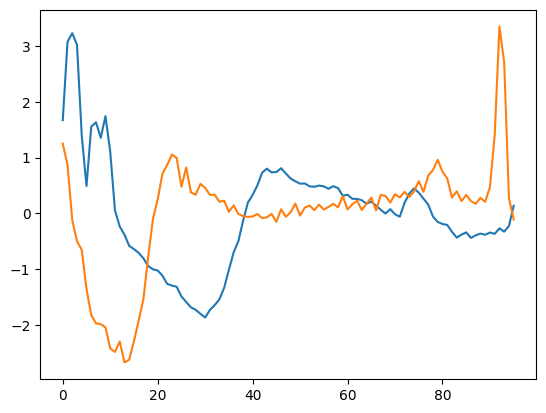

In [46]:
plt.plot(X_train[8])
plt.plot(X_train[16])

plt.show()

### Class Based Analysis

In [20]:
import importlib
tsmorph = importlib.import_module('tsmorph-xai.tsmorph.tsmorph')
TSmorph = tsmorph.TSmorph

def ClassMorphingCalculater(X, y):
    pairs = []
    # create list of tuples (key, element[i])
    for key in borderline_pairs:
        for i in range(len(borderline_pairs[key])):
            pairs.append([key, borderline_pairs[key][i]])

    results = {}
    for sample in pairs:
        source_ts = np.array(X[sample[0]])
        target_ts = np.array(X[sample[1]])

        morphing = TSmorph(S=source_ts, T=target_ts, granularity=granularity+2).transform()
        morphing = morphing.T

        #print(X.shape)
        #print(morphing.shape)

        # Predict new labels using selected model
        if isinstance(model, tf.keras.Model):
            pred = model.predict(morphing)
            pred = np.where(pred > 0.5, 1, 0)

        elif catch22_features:
            features = compute_catch22_features(morphing)
            pred = model.predict(features)

        elif kernels != None:
            morphing = np.array(morphing, dtype=np.float64)
            morphing_transform = apply_kernels(morphing, rocket_kernels)
            pred = model.predict(morphing_transform)


        # check if model predictions from orginal time series are correct
        if (y[sample[0]] == pred[0] and y[sample[1]] == pred[-1]):
            change_idx = 1
            for i in range(1, len(pred)-1):  # account for both original series
                #print(pred[0], pred[i])
                if pred[0] != pred[i]:
                    change_idx = i
                    break
            morph_perc = 1/granularity * change_idx
            results[(sample[0], sample[1])] = round(morph_perc, 2)
        else: continue

    return results

## Fancy Plotting

In [21]:
import matplotlib.pyplot as plt

def plot_gradient_timeseries(df, start_color='#61E6AA', end_color='#5722B1'):
    # Convert hex to RGB
    def hex_to_rgb(hex_color):
        hex_color = hex_color.lstrip('#')
        return tuple(int(hex_color[i:i+2], 16)/255 for i in (0, 2, 4))

    # Generate gradient colors
    start_rgb = hex_to_rgb(start_color)
    end_rgb = hex_to_rgb(end_color)
    n_series = len(df.columns)

    colors = []
    for i in range(n_series):
        ratio = i / (n_series - 1)
        r = start_rgb[0] + (end_rgb[0] - start_rgb[0]) * ratio
        g = start_rgb[1] + (end_rgb[1] - start_rgb[1]) * ratio
        b = start_rgb[2] + (end_rgb[2] - start_rgb[2]) * ratio
        colors.append((r, g, b))

    # Create the plot
    plt.figure(figsize=(12, 6))

    # Plot each series with its corresponding color
    for idx, column in enumerate(df.columns):
        plt.plot(df.index, df[column], color=colors[idx], label=column, linewidth=2)

    # Customize the plot
    plt.title('Time Series with Gradient Transformation', fontsize=14, pad=15)
    plt.xlabel('Time', fontsize=12)
    plt.ylabel('Value', fontsize=12)
    plt.grid(True, alpha=0.3)
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')

    # Adjust layout to prevent label cutoff
    plt.tight_layout()
    plt.show()
    return

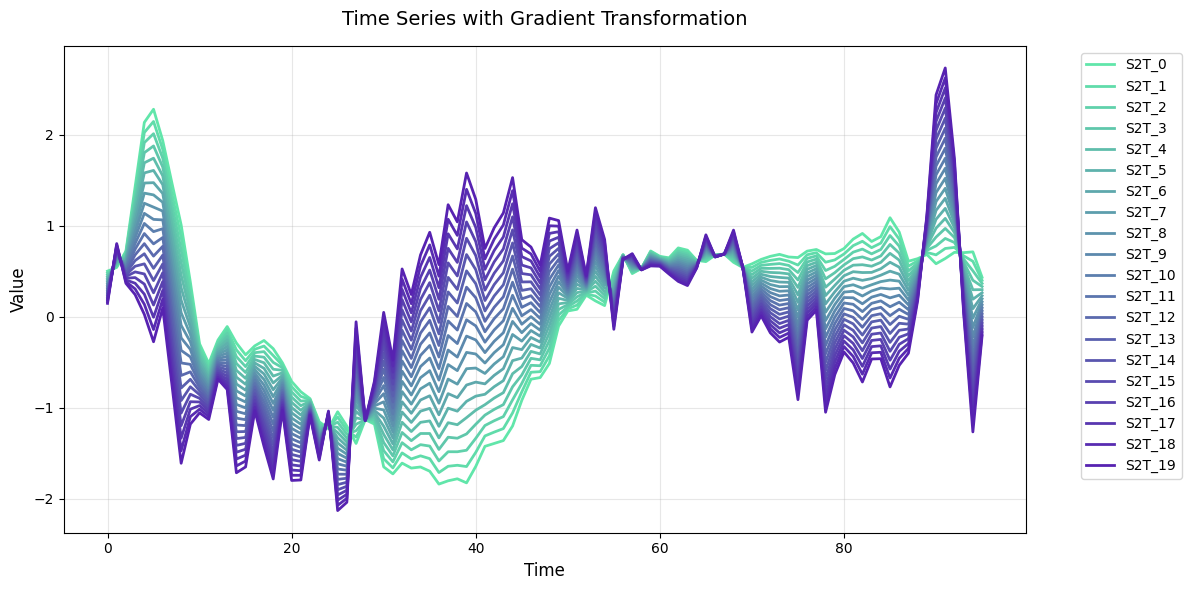

In [22]:
source_ts = X[0]
target_ts = X[1]

morphing = TSmorph(S=source_ts, T=target_ts, granularity=20).transform()

plot_gradient_timeseries(morphing)